## Tibetan convective systems 

Script to filter out only convective cells which are (at least partly) over the TP 





In [3]:
import numpy as np 
import xarray as xr 
import pandas as pd
import warnings
import os 
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import cartopy 
import cartopy.crs as ccrs
import matplotlib.colors as colors
import shapely.geometry as sgeom


In [5]:
# read in example tracks 
savedir= '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking' 
tracks = pd.read_hdf(savedir + '/Tracks_tbb_2004_heavyraincorefiltered.h5', 'table')

In [6]:
tracks.shape

(4479, 18)

In [10]:
tracks[tracks.tp_flag > 0]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,ncells,cell,time_cell,rain_flag,tp_flag,total_precip,convective_precip
44676,7595,300,13.546750,98.815044,138,200,1349,2004-05-07 06:00:00,2004-05-07 06:00:00,16.304675,69.931502,580,25322.0,03:00:00,223,9,1807.699463,753.188965
44994,7624,329,7.991368,115.099305,279,195,1667,2004-05-07 20:30:00,2004-05-07 20:30:00,15.749137,71.559933,945,25534.0,02:00:00,155,1034,1250.671021,948.474365
45187,7650,355,18.607011,98.052138,289,205,1860,2004-05-08 09:30:00,2004-05-08 09:30:00,16.810701,69.855212,1563,25639.0,01:30:00,32,362,346.438995,134.975235
47096,7855,560,82.725668,355.442998,195,205,3769,2004-05-12 16:00:00,2004-05-12 16:00:00,23.222567,95.594302,465,26269.0,03:30:00,428,44,3716.093506,2947.239502
47604,7897,602,59.903424,258.844598,240,200,4277,2004-05-13 13:00:00,2004-05-13 13:00:00,20.940343,85.934457,368,26446.0,01:30:00,479,49,4420.876953,2955.659912
47638,7899,604,94.750693,310.774199,337,195,4311,2004-05-13 14:00:00,2004-05-13 14:00:00,24.425070,91.127422,1272,26465.0,00:30:00,444,45,3092.579590,2503.949707
47664,7901,606,94.296596,313.844522,497,195,4337,2004-05-13 15:00:00,2004-05-13 15:00:00,24.379660,91.434449,1486,26465.0,01:30:00,430,46,2947.777344,2370.501465
47704,7905,610,56.731856,250.106578,125,210,4377,2004-05-13 17:00:00,2004-05-13 17:00:00,20.623185,85.060661,385,26446.0,05:30:00,308,18,2255.921387,1564.254395
47789,7913,618,97.369201,309.647724,125,195,4462,2004-05-13 21:00:00,2004-05-13 21:00:00,24.686920,91.014773,1304,26465.0,07:30:00,418,15,4219.263184,3630.059326
47817,7915,620,97.203088,315.585087,301,200,4490,2004-05-13 22:00:00,2004-05-13 22:00:00,24.670308,91.608511,1712,26465.0,08:30:00,711,13,5402.846191,4104.628906


In [498]:
## elevation mask 

dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xr.open_dataarray(dem)
 
# mask as coordinates 
dem_mask = elevations.where(elevations >= 3000)
dem_mask.coords['mask'] = (('lon', 'lat'), dem_mask)

dem_mask.shape

(600, 350)

In [525]:
#prec= p[:,1:,1:]
elev = elevations.data.T
elev.shape

(350, 600)

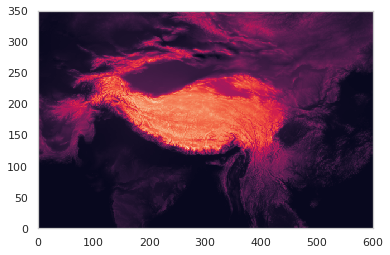

In [526]:
import matplotlib.pyplot as plt
plt.pcolormesh(elev)
plt.show()

In [86]:
removed = 0 
tracks['tp_flag'] = 0 

# loop through cells 
for cell in np.unique(tracks.cell.values):
    subset = tracks[tracks.cell == cell]
    print('checking heavy rain cores for cell:', cell, subset.shape)
    tp_flag = 0 
    # loop through timesteps of features for specific cell 
    for idx in subset.idx.values: 
        # idx is the timestep index for respective timestep or mask file 
    
        # open corresponding precip and mask file 
        year = subset.time.values[0].year 
        month = subset.time.values[0].month
        if len(str(month))== 1: 
            month= '0' + str(month)
            
        # check whether segmented feature is in area above 3000 m 
        maskfile = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Mask_Segmentation_'+str(year) + str(month) + '.nc'
        mask = xr.open_dataarray(maskfile)
        mask= mask[:,1:,1:].T
        
        # get right timestep frames 
        seg= mask[:,:,idx]

        # get feature ID for frame 
        featureid= subset.feature[subset.idx== idx].values[0]
        
        # create mask as coordinates 
        seg_mask = seg.where(seg == featureid)
        seg_mask.coords['mask'] = (('lon', 'lat'), seg_mask)
        # apply mask on precip data to extract precip values for feature in cell 
        elevation_values = dem_mask.where(seg_mask.coords['mask'].values > 1)
        arr= elevation_values.values.flatten()
        values = arr[~np.isnan(arr)]
        mountain_features = values[values >=3000].shape[0]
                
        if mountain_features >= 10: 
            tp_flag += mountain_features
            # percentage of area which lies within TP boundary 
            percentage= tp_flag / tracks[tracks.feature == featureid].ncells.values[0]
            tracks['tp_flag'][tracks.feature == featureid] =  percentage

            
            
    if tp_flag ==  0: 
        # remove corresponding cell from track dataframe 
        tracks = tracks.drop(tracks[tracks.cell == cell].index)
        print(cell, ' removed, because it is outside of the 3000 m boundary.')
        removed += 1 
    else:
        print('cell is over TP:  ', cell)
    
    
tracks.to_hdf(os.path.join(savedir,'Tracks_tbb_TPflag.h5'),'table')    

checking heavy rain cores for cell: 24320.0 (13, 15)
24320.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24839.0 (10, 15)
24839.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24872.0 (8, 15)
24872.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24874.0 (18, 15)
24874.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24936.0 (15, 15)
24936.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 24979.0 (15, 15)
24979.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 25322.0 (17, 15)
25322.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 25534.0 (15, 15)
25534.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 25639.0 (15, 15)
25639.0  rem

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   26465.0
checking heavy rain cores for cell: 26543.0 (10, 15)
26543.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26583.0 (16, 15)
26583.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26609.0 (10, 15)
26609.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26621.0 (16, 15)
26621.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26648.0 (22, 15)
26648.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26675.0 (19, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   26675.0
checking heavy rain cores for cell: 26709.0 (12, 15)
26709.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26739.0 (10, 15)
26739.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26766.0 (10, 15)
26766.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26792.0 (21, 15)
26792.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26812.0 (8, 15)
26812.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26875.0 (9, 15)
26875.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26886.0 (10, 15)
26886.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 26908.0 (14, 15)
26908.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 269

30093.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30135.0 (14, 15)
30135.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30143.0 (20, 15)
30143.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30154.0 (11, 15)
30154.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30174.0 (12, 15)
30174.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30212.0 (13, 15)
30212.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30263.0 (15, 15)
30263.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30272.0 (14, 15)
30272.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 30281.0 (12, 15)
30281.0  removed, because it is outside of the 3000 m boundary.


32454.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32525.0 (20, 15)
32525.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32605.0 (9, 15)
32605.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32718.0 (14, 15)
32718.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32736.0 (16, 15)
32736.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32842.0 (7, 15)
32842.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32852.0 (11, 15)
32852.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32859.0 (7, 15)
32859.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 32922.0 (10, 15)
32922.0  removed, because it is outside of the 3000 m boundary.
che

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   33769.0
checking heavy rain cores for cell: 33786.0 (26, 15)
33786.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 33813.0 (14, 15)
33813.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34038.0 (13, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   34038.0
checking heavy rain cores for cell: 34041.0 (8, 15)
34041.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34154.0 (13, 15)
34154.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34170.0 (25, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   34170.0
checking heavy rain cores for cell: 34305.0 (12, 15)
34305.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34364.0 (10, 15)
34364.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34397.0 (11, 15)
34397.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34459.0 (10, 15)
34459.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34500.0 (11, 15)
34500.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34528.0 (8, 15)
34528.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34538.0 (15, 15)
34538.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34546.0 (14, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   34546.0
checking heavy rain cores for cell: 34581.0 (13, 15)
34581.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34706.0 (8, 15)
34706.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34731.0 (21, 15)
34731.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 34810.0 (17, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   34810.0
checking heavy rain cores for cell: 34955.0 (15, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   34955.0
checking heavy rain cores for cell: 35188.0 (13, 15)
35188.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35486.0 (19, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   35486.0
checking heavy rain cores for cell: 35537.0 (25, 15)
35537.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35552.0 (16, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   35552.0
checking heavy rain cores for cell: 35709.0 (15, 15)
35709.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35784.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   35784.0
checking heavy rain cores for cell: 35897.0 (7, 15)
35897.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35938.0 (8, 15)
35938.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35957.0 (15, 15)
35957.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 35974.0 (12, 15)
35974.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36203.0 (8, 15)
36203.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36275.0 (12, 15)
36275.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36371.0 (7, 15)
36371.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36393.0 (8, 15)
36393.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 36596.

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   37675.0
checking heavy rain cores for cell: 37724.0 (18, 15)
37724.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 37796.0 (20, 15)
37796.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 37809.0 (8, 15)
37809.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 37861.0 (20, 15)
37861.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 38008.0 (14, 15)
38008.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 38032.0 (11, 15)
38032.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 38040.0 (10, 15)
38040.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 38056.0 (7, 15)
38056.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 380

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   39860.0
checking heavy rain cores for cell: 39903.0 (12, 15)
39903.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 39910.0 (17, 15)
39910.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 39982.0 (23, 15)
39982.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40173.0 (9, 15)
40173.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40272.0 (16, 15)
40272.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40318.0 (12, 15)
40318.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40394.0 (10, 15)
40394.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40426.0 (13, 15)
40426.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 40

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   41450.0
checking heavy rain cores for cell: 41584.0 (14, 15)
41584.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 41831.0 (21, 15)
41831.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 41856.0 (10, 15)
41856.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 41904.0 (9, 15)
41904.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 41970.0 (8, 15)
41970.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 42222.0 (9, 15)
42222.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 42262.0 (7, 15)
42262.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 42291.0 (18, 15)
42291.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 42298

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   45205.0
checking heavy rain cores for cell: 45285.0 (7, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   45285.0
checking heavy rain cores for cell: 45419.0 (7, 15)
45419.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45457.0 (15, 15)
45457.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45486.0 (8, 15)
45486.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45644.0 (17, 15)
45644.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45657.0 (7, 15)
45657.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 45936.0 (26, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   45936.0
checking heavy rain cores for cell: 45945.0 (14, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   45945.0
checking heavy rain cores for cell: 45981.0 (13, 15)
45981.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46030.0 (14, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46030.0
checking heavy rain cores for cell: 46040.0 (19, 15)
46040.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46103.0 (17, 15)
46103.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46166.0 (7, 15)
46166.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46208.0 (7, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46208.0
checking heavy rain cores for cell: 46212.0 (24, 15)
46212.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46240.0 (8, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46240.0
checking heavy rain cores for cell: 46243.0 (21, 15)
46243.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46285.0 (8, 15)
46285.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46304.0 (9, 15)
46304.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46313.0 (10, 15)
46313.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46327.0 (12, 15)
46327.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46336.0 (23, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46336.0
checking heavy rain cores for cell: 46383.0 (18, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46383.0
checking heavy rain cores for cell: 46391.0 (8, 15)
46391.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46446.0 (43, 15)
46446.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46551.0 (7, 15)
46551.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46569.0 (42, 15)
46569.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46789.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   46789.0
checking heavy rain cores for cell: 46808.0 (8, 15)
46808.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46963.0 (16, 15)
46963.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 46966.0 (7, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   46966.0
checking heavy rain cores for cell: 46998.0 (11, 15)
46998.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47116.0 (15, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   47116.0
checking heavy rain cores for cell: 47235.0 (26, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   47235.0
checking heavy rain cores for cell: 47287.0 (21, 15)
47287.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47295.0 (8, 15)
47295.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47358.0 (8, 15)
47358.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47580.0 (14, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   47580.0
checking heavy rain cores for cell: 47699.0 (16, 15)
47699.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47703.0 (19, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   47703.0
checking heavy rain cores for cell: 47771.0 (12, 15)
47771.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47867.0 (7, 15)
47867.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 47928.0 (35, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   47928.0
checking heavy rain cores for cell: 48157.0 (18, 15)
48157.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48158.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   48158.0
checking heavy rain cores for cell: 48336.0 (14, 15)
48336.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48337.0 (10, 15)
48337.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48371.0 (30, 15)
48371.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48600.0 (9, 15)
48600.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48626.0 (18, 15)
48626.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48746.0 (9, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   48746.0
checking heavy rain cores for cell: 48770.0 (10, 15)
48770.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48870.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   48870.0
checking heavy rain cores for cell: 48892.0 (9, 15)
48892.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48945.0 (12, 15)
48945.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 48959.0 (17, 15)
48959.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49003.0 (15, 15)
49003.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49082.0 (9, 15)
49082.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49172.0 (14, 15)
49172.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49186.0 (17, 15)
49186.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 49255.0 (11, 15)
49255.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 492

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   51765.0
checking heavy rain cores for cell: 51797.0 (11, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cell is over TP:   51797.0
checking heavy rain cores for cell: 51813.0 (18, 15)
51813.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 51829.0 (8, 15)
51829.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 51830.0 (22, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   51830.0
checking heavy rain cores for cell: 51975.0 (8, 15)
51975.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 51985.0 (11, 15)
51985.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 52113.0 (20, 15)
52113.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 52123.0 (7, 15)
52123.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 52129.0 (14, 15)
52129.0  removed, because it is outside of the 3000 m boundary.
checking heavy rain cores for cell: 52147.0 (35, 15)


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a 

cell is over TP:   52147.0
checking heavy rain cores for cell: 53142.0 (72, 15)
53142.0  removed, because it is outside of the 3000 m boundary.


/home/juli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['time', 'timestr']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Example for Tibetan convective system : step-by-step plot

In [120]:
tracks[tracks.cell== 46336.0]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,ncells,cell,time_cell,tp_flag
121123,12988,1277,119.488823,262.677871,127,220,19717,2004-08-27 14:30:00,2004-08-27 14:30:00,26.898883,86.317786,297,46336.0,00:00:00,37
121140,12989,1278,119.676425,263.162668,120,215,19734,2004-08-27 15:00:00,2004-08-27 15:00:00,26.917643,86.366265,313,46336.0,00:30:00,65
121159,12990,1279,119.517083,263.438322,122,210,19753,2004-08-27 15:30:00,2004-08-27 15:30:00,26.901709,86.393830,517,46336.0,01:00:00,100
121179,12991,1280,119.593042,264.028922,134,210,19773,2004-08-27 16:00:00,2004-08-27 16:00:00,26.909305,86.452889,469,46336.0,01:30:00,146
121198,12992,1281,119.111343,265.073317,106,205,19792,2004-08-27 16:30:00,2004-08-27 16:30:00,26.861135,86.557335,519,46336.0,02:00:00,210
121215,12993,1282,118.658374,267.489735,142,205,19809,2004-08-27 17:00:00,2004-08-27 17:00:00,26.815838,86.798973,565,46336.0,02:30:00,286
121232,12994,1283,117.697293,270.470951,172,205,19826,2004-08-27 17:30:00,2004-08-27 17:30:00,26.719729,87.097097,751,46336.0,03:00:00,375
121248,12995,1284,116.403955,272.394735,151,205,19842,2004-08-27 18:00:00,2004-08-27 18:00:00,26.590395,87.289473,937,46336.0,03:30:00,476
121264,12996,1285,116.375049,273.220784,132,205,19858,2004-08-27 18:30:00,2004-08-27 18:30:00,26.587504,87.372077,951,46336.0,04:00:00,583
121280,12997,1286,116.793548,275.373568,169,205,19874,2004-08-27 19:00:00,2004-08-27 19:00:00,26.629354,87.587359,768,46336.0,04:30:00,688


In [112]:
for feature in np.unique(tracks.feature.values):
    if tracks[tracks.feature == feature].ncells.values[0] == tracks[tracks.feature == feature].tp_flag.values[0]:
        print(feature)
    #else:
        #print('only percentage:',tracks[tracks.feature == feature].ncells.values[0]/  tracks[tracks.feature == feature].tp_flag.values[0] )

19992


In [98]:
for cell in np.unique(tracks.cell.values):
    subset= tracks[tracks.cell == cell ]
    if subset.tp_flag.values[0]> 0:
        print(cell, subset.shape[0]*0.5)

34038.0 6.5
34546.0 7.0
35552.0 8.0
37675.0 4.0
39860.0 8.5
45936.0 13.0
45945.0 7.0
46208.0 3.5
46240.0 4.0
46336.0 11.5
46383.0 9.0
46966.0 3.5
47116.0 7.5
47235.0 13.0
47580.0 7.0
47703.0 9.5
47928.0 17.5
48746.0 4.5
51765.0 5.0
51830.0 11.0


In [57]:
600*350 -  elevations.data[elevations>= 3000].shape[0]

180337

In [52]:
## Import elevation file for 3000 m boundary 
import xarray 

dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
elevations.shape




(600, 350)

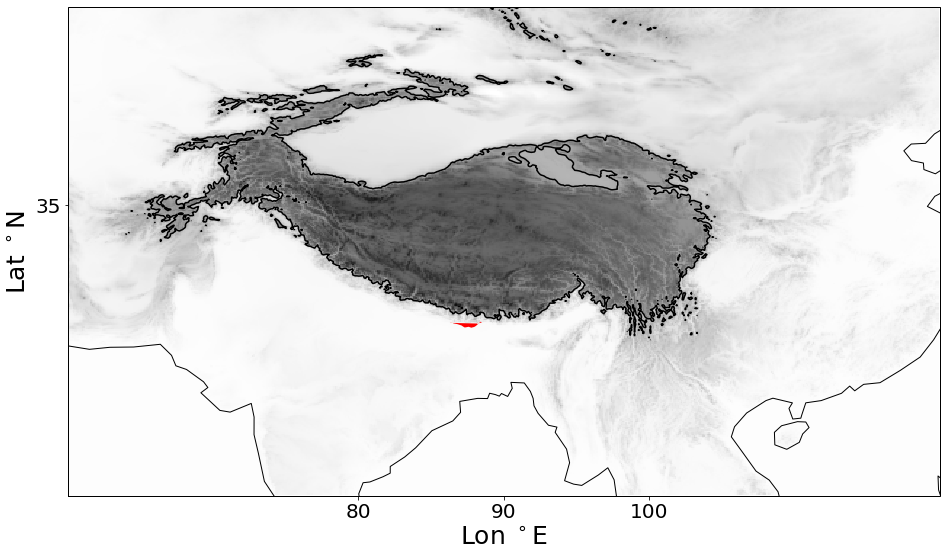

In [174]:
# plot background DEM 
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import matplotlib.colors as colors
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

plt.figure(figsize=(20,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([60,120,15,45])

# 3000 m boundary 
ax.contour(elevations.lon.values,elevations.lat.values, elevations.values.T, [3000], cmap = 'Greys_r')

cmap=plt.cm.viridis

m = ax.pcolormesh(elevations.lon.values,elevations.lat.values, elevations.values.T, cmap = 'Greys')



# plot track 
storm= tracks[tracks.cell == 46336]
track = sgeom.LineString(zip(storm.longitude.values, storm.latitude.values))
ax.add_geometries([track], ccrs.PlateCarree(),facecolor='red')

xlabels=[80,90,100]
ylabels= [35]
plt.xticks(xlabels, xlabels, fontsize=20)
plt.yticks(ylabels,ylabels, fontsize=20)
plt.xlabel('Lon $^\circ$E',  fontsize=25)
plt.ylabel('Lat $^\circ$N',  fontsize=25)


ax.coastlines()

#cbar= plt.colorbar(m, extend = 'max')
#cbar.set_ticks([240,250,260,270,280,290,300])
#cbar.set_label('elevation (m)', fontsize = 15)

plt.savefig('example_track_2004.png')
plt.show()


# plot track 




# subplot with initiation, majurity and dissipation 




## Case for cell evolution : July 2008 

In [444]:
# read in example tracks 
savedir= '/media/juli/Elements/gpm_v06/Save/2000_2019/Tracks_precipitation_GPM_2008.h5' 

ptracks = pd.read_hdf(savedir, 'table')

ptracks = ptracks[ptracks.cell >= 0]
ptracks.timestr = pd.to_datetime(ptracks.timestr)
ptracks['month']= ptracks.timestr.dt.month
ptracks['day']= ptracks.timestr.dt.day
ptracks['hour']= ptracks.timestr.dt.hour
july = ptracks[ptracks.month == 7]
tpv_precip = july[july.day == 20]


In [455]:
tpv_precip[tpv_precip.cell == 24071.0]

tpv_precip[tpv_precip.cell ==24022.0]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells,cell,time_cell,month,day,hour
108419,11156,933,437.954731,147.496891,15,5,26665,2008-07-20 10:30:00,2008-07-20 10:30:00,103.845472,29.699689,105,24022.0,00:00:00,7,20,10
108452,11157,934,438.003761,147.439643,23,5,26698,2008-07-20 11:00:00,2008-07-20 11:00:00,103.850375,29.693964,64,24022.0,00:30:00,7,20,11
108492,11158,935,437.219603,147.969652,15,15,26738,2008-07-20 11:30:00,2008-07-20 11:30:00,103.771960,29.746965,249,24022.0,01:00:00,7,20,11
108509,11159,936,437.744429,148.763528,39,15,26755,2008-07-20 12:00:00,2008-07-20 12:00:00,103.824442,29.826353,245,24022.0,01:30:00,7,20,12
108528,11160,937,437.813078,148.877498,48,15,26774,2008-07-20 12:30:00,2008-07-20 12:30:00,103.831307,29.837750,239,24022.0,02:00:00,7,20,12
108546,11161,938,435.241242,147.764692,67,15,26792,2008-07-20 13:00:00,2008-07-20 13:00:00,103.574127,29.726469,378,24022.0,02:30:00,7,20,13
108560,11162,939,435.325444,147.440915,62,15,26806,2008-07-20 13:30:00,2008-07-20 13:30:00,103.582547,29.694091,545,24022.0,03:00:00,7,20,13
108578,11163,940,433.252820,147.722899,35,15,26824,2008-07-20 14:00:00,2008-07-20 14:00:00,103.375280,29.722290,113,24022.0,03:30:00,7,20,14
108596,11164,941,433.252820,147.722899,35,15,26842,2008-07-20 14:30:00,2008-07-20 14:30:00,103.375280,29.722290,113,24022.0,04:00:00,7,20,14
108618,11165,942,436.116859,146.850129,71,15,26864,2008-07-20 15:00:00,2008-07-20 15:00:00,103.661687,29.635012,850,24022.0,04:30:00,7,20,15


In [4]:
# read in example tracks tbb
savedir= '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/Tracks_2008_heavyraincorefiltered.h5' 
tracks = pd.read_hdf(savedir, 'table')
tracks.timestr = pd.to_datetime(tracks.timestr)
tracks['month']= tracks.timestr.dt.month
tracks['day']= tracks.timestr.dt.day
tracks['hour']= tracks.timestr.dt.hour

In [5]:
july = tracks[tracks.month == 7]
tpv = tracks[tracks.cell == 14548.0]

## evolution plot 

In [412]:
#tpv.rain_flag[tpv.feature == 18158] = 250

In [6]:
day=july[july.day == 20 ]
day[day.hour == 17]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,...,ncells,cell,time_cell,rain_flag,tp_flag,total_precip,convective_precip,month,day,hour
98377,11169,946,142.342319,444.073444,524,200,18294,2008-07-20 17:00:00,2008-07-20 17:00:00,29.184232,...,3062,14548.0,08:00:00,9,1058,527.651001,28.876123,7,20,17
98391,11170,947,143.167786,444.923976,584,200,18308,2008-07-20 17:30:00,2008-07-20 17:30:00,29.266779,...,3338,14548.0,08:30:00,2,1257,380.943787,5.633443,7,20,17


<Figure size 432x288 with 0 Axes>

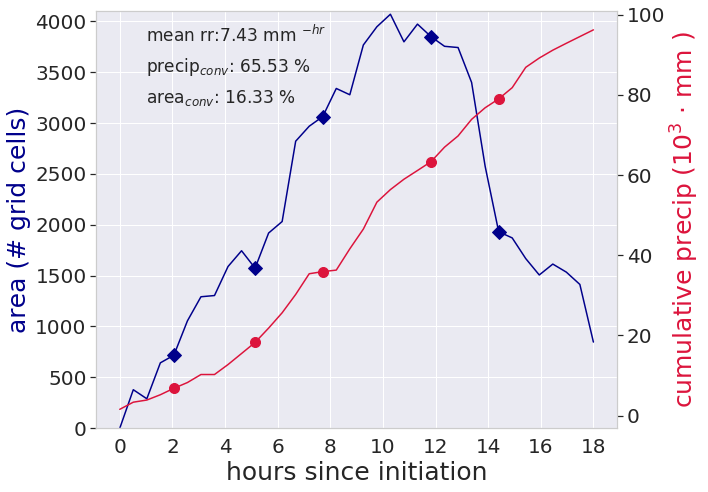

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

timesteps= np.linspace(0,18, 36)
plt.clf()

# convert ncells to area 
area = tpv.ncells.values * 14.126 * 14.126
area = area.astype(int)

fig, ax1 = plt.subplots(figsize=(10,7))


ax1.set_xlabel('hours since initiation', fontsize = 25)
ax1.set_ylabel('area (# grid cells)', fontsize = 25, color= 'darkblue')
ax1.set_yticks(np.arange(0,4500)[::500]) 
ax1.set_yticklabels(np.arange(0,4500)[::500], fontsize= 20)

markers_on = [4, 10, 15, 23,28]
ax1.plot(timesteps, tpv.ncells.values,'-kD', markevery= markers_on, color= 'darkblue', markersize = 10)


ax1.set_ylim(0,4100)


sns.set_style("whitegrid", {'axes.grid' : False})
ax2 = ax1.twinx()  #
color = 'crimson'
ax2.set_ylabel('cumulative precip (10$^3$ $\cdot$ mm )', fontsize =25, color=color)
ax2.plot(timesteps, np.cumsum(tpv.total_precip.values)/1000,'-ko',  markevery= markers_on, color= 'crimson', markersize = 10)
ax2.set_yticks(np.arange(0,120)[::20]) 
ax2.set_yticklabels(np.arange(0,120)[::20], fontsize= 20)


total = np.sum(tpv.total_precip.values) / np.sum(tpv.rain_flag.values)
text1= 'mean rr:' + str(np.round(total, decimals = 2)) + ' mm $^{-hr}$'
contr= np.round(np.sum(tpv.convective_precip.values) / np.sum(tpv.total_precip.values ) * 100, decimals=2)
text2 = 'precip$_{conv}$: ' + str(contr) + ' %'
convective = np.sum(tpv.rain_flag)/np.sum(tpv.ncells.values)*100
text3 = 'area$_{conv}$: ' + str(np.round(convective, decimals = 2)) + ' %'

ax1.text(1,3800, text1, fontsize =17)
ax1.text(1,3500, text2, fontsize =17)
ax1.text(1,3200, text3, fontsize =17)
ax1.set_xticks(np.arange(0,20)[::2])
ax1.set_xticklabels(np.arange(0,20)[::2], fontsize= 20)

#plt.plot(timesteps, tpv.total_precip.values, color= 'darkblue')
#plt.plot(timesteps, tpv.convective_precip.values, color= 'teal')
plt.tight_layout()

plt.savefig('plots/evolution_tpv_july2008.png')
plt.show()


## plot each time step to follow evolution 



In [578]:
## import necessary data 
import xarray as xr 

from netCDF4 import Dataset 
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import matplotlib.colors as colors


tbbdir = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/'
mcsdir = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking'

## Import elevation file for 3000 m boundary 

dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xr.open_dataarray(dem)


# read in half hourly TBB 
import xarray 

file = tbbdir+ '2009/merg_200910.nc4'
dataset = xr.open_dataarray(file)
lat= dataset.lat.values
lon= dataset.lon.values
time= dataset.time.values
mcs = dataset.values 


# precip data 

file = '/media/juli/Elements/gpm_v06/2009/gpm_imerg_200910_monthly.nc4'
dataset = xr.open_dataarray(file)
precip_lat= dataset.lat.values
precip_lon= dataset.lon.values
precip_time= dataset.time.values
precip = dataset.values 

In [579]:
# read in masks

mcsdir = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/'
file =mcsdir+ 'Mask_Segmentation_200910.nc'
mask = xr.open_dataarray(file)
mask = mask.values

In [580]:
# read in masks
p = '/media/juli/Elements/gpm_v06/Save/2000_2019/Mask_Segmentation_precip200910.nc'
data= xr.open_dataarray(p)
pmask = data.values

In [585]:
timeseries= np.arange(307,308) # range of timesteps 


In [462]:
d= july[july.day == 21]
ptracks[ptracks.cell == 24111.0]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells,cell,time_cell,month,day,hour
108813,11178,955,447.562855,147.210291,13,15,27059,2008-07-20 21:30:00,2008-07-20 21:30:00,104.806285,29.671029,112,24111.0,00:00:00,7,20,21
108834,11179,956,447.562855,147.210291,13,15,27080,2008-07-20 22:00:00,2008-07-20 22:00:00,104.806285,29.671029,112,24111.0,00:30:00,7,20,22
108871,11181,958,449.211079,146.932996,15,15,27117,2008-07-20 23:00:00,2008-07-20 23:00:00,104.971106,29.643299,1713,24111.0,01:30:00,7,20,23
108895,11182,959,449.114236,146.582061,14,15,27141,2008-07-20 23:30:00,2008-07-20 23:30:00,104.961421,29.608206,148,24111.0,02:00:00,7,20,23
108916,11183,960,449.695889,146.359475,15,10,27162,2008-07-21 00:00:00,2008-07-21 00:00:00,105.019590,29.585947,583,24111.0,02:30:00,7,21,0
108938,11184,961,450.586512,146.040129,12,10,27184,2008-07-21 00:30:00,2008-07-21 00:30:00,105.108653,29.554012,579,24111.0,03:00:00,7,21,0
108958,11185,962,452.323485,157.169974,17,10,27204,2008-07-21 01:00:00,2008-07-21 01:00:00,105.282348,30.666997,366,24111.0,03:30:00,7,21,1


In [289]:
tpv_precip[tpv_precip.cell== 24022.0]
tpv_precip[tpv_precip.cell == 24071.0]

lifetimes= {}
for c in np.unique(ptracks.cell.values):
    cell= ptracks[ptracks.cell == c]
    lifetimes[str(c)]=  np.shape(cell)[0]*0.5

In [582]:
from scipy import ndimage
from scipy.ndimage import generate_binary_structure
s= generate_binary_structure(2,2)

307


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


<Figure size 432x288 with 0 Axes>

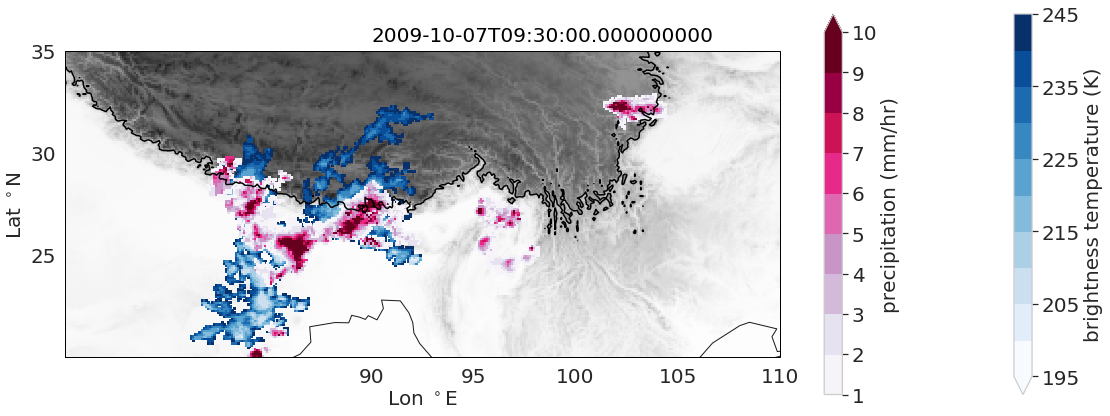

In [587]:
for t in timeseries:
    print(t)
    plt.clf()
    cmaps = ['PuRd', 'PuRd', 'pink', 'Oranges', 'Blues']
    
    # timeslot of tb and precip data
    mcs_example=mcs[t,:,:]
    precip_example=precip[t,:,:]
    
    # mask for tracked MCS 
    mcs_mask = mask[t,:,:]
    #feature= tpv[tpv.idx ==t].feature.values[0]
    feature = 2991
    labels, nr = ndimage.label(mcs_mask, structure = s)
    label = labels[mcs_mask == feature][0]

    # mask for tracked precip features 
    precip_mask = pmask[t,:,:]
    features = np.unique(tpv_precip[tpv_precip.idx ==t].feature.values)

    plt.figure(figsize=(20,7))
    ax1 = plt.axes(projection=ccrs.PlateCarree())             
    ax1.set_extent([75,95,20, 30])
    #ax1.set_extent([np.nanmin(lon), np.nanmax(lon),np.nanmin(lat), 45])

    # 3000 m boundary 
    ax1.contour(elevations.lon.values,elevations.lat.values, elevations.values.T,[3000], cmap = 'Greys_r')
    ax1.pcolormesh(elevations.lon.values,elevations.lat.values, elevations.values.T,  cmap = 'Greys')
    
    # define the bins and normalize
    cmap=plt.cm.viridis
    norm = colors.BoundaryNorm(np.arange(195,250,5), cmap.N)
    
    # show values for segmentation mask
    #ma = np.ma.masked_array(mcs_example, mcs_example > 245 )  
    mcs_example[mcs_example >= 245 ] = 0
    labels, nr = ndimage.label(mcs_example, structure = s)
    label = labels[mcs_mask == feature][0]
    z = np.ma.masked_array(mcs_example, labels != label )

    m= ax1.pcolormesh(lon, lat, z, transform= ccrs.PlateCarree(), cmap= 'Blues', norm=norm, vmin = 200, vmax = 245 )

    precip_scale = np.arange(1,11,1)
    norm = colors.BoundaryNorm(precip_scale, cmap.N)
    prec_mask = np.ma.masked_array(precip_example, precip_mask < 1 )
    

    p = ax1.pcolormesh(precip_lon, precip_lat, prec_mask.T, transform= ccrs.PlateCarree(), cmap= cmaps[0] ,norm=norm, vmin = 1.0 , vmax = 15.0)
          

    # plot track 
    #ax1.plot(tpv.longitude.values, tpv.latitude.values, color='black', marker = 'o')
    
    #lo = tpv[tpv.idx ==t].longitude.values[0]
    #la= tpv[tpv.idx ==t].latitude.values[0]
    #ax1.plot(lo,la, markersize=15, marker='o', color = 'crimson',  transform=ccrs.PlateCarree())
        
    xlabels=[90, 95,  100, 105, 110]
    ylabels= [25, 30, 35]
    ax1.set_xticks(xlabels)
    ax1.set_xticklabels(xlabels, fontsize= 20) 
    ax1.set_yticklabels(ylabels, fontsize= 20) 
    ax1.set_yticks(ylabels)
    ax1.set_xlabel('Lon $^\circ$E', fontsize= 20)
    ax1.set_ylabel('Lat $^\circ$N', fontsize= 20)
    ax1.coastlines(color = 'k')

    cbar= plt.colorbar(m,extend = 'min')
    cbar.set_label('brightness temperature (K)', fontsize = 20)
    cbar.ax.tick_params(labelsize=20) 
    
    cbar2= plt.colorbar(p,extend = 'max')
    cbar2.set_label('precipitation (mm/hr)', fontsize = 20)
    cbar2.ax.tick_params(labelsize=20) 
    
    plt.tight_layout()
        
    timestr = time[t]
    ax1.text(90, 35.5, timestr, fontsize = 20, color = 'black')

    plt.savefig('plots/Example_precip_feature_200910_'+ str(t) + '.png')
    plt.show()


In [ ]:
    # for multiple tracks in precip data 
    for f in features:
        if tpv_precip[tpv_precip.feature == f].cell.values[0] == 24071.0:
            cmap = cmaps[0]
            labels, nr = ndimage.label(precip_mask, structure = s)
            label = labels[precip_mask == f][0]
            prec_mask = np.ma.masked_array(precip_example, labels != label )
            p = ax1.contour(precip_lon, precip_lat, prec_mask.T, transform= ccrs.PlateCarree(), cmap= cmap ,levels = [0,1,5,10,15,20], linewidths= 3.5)

        if  tpv_precip[tpv_precip.feature == f].cell.values[0] == 24022.0:
            cmap = cmaps[0]        
            labels, nr = ndimage.label(precip_mask, structure = s)
            label = labels[precip_mask == f][0]
            prec_mask = np.ma.masked_array(precip_example, labels != label )
            p = ax1.contour(precip_lon, precip_lat, prec_mask.T, transform= ccrs.PlateCarree(), cmap= cmap ,levels = [0,1,5,10,15,20], linewidths = 3.5)
            
        if  tpv_precip[tpv_precip.feature == f].cell.values[0] == 24023.5 or tpv_precip[tpv_precip.feature == f].cell.values[0] == 24111.0:
            cmap = cmaps[0]        
            labels, nr = ndimage.label(precip_mask, structure = s)
            label = labels[precip_mask == f][0]
            prec_mask = np.ma.masked_array(precip_example, labels != label )
            p = ax1.contour(precip_lon, precip_lat, prec_mask.T, transform= ccrs.PlateCarree(), cmap= cmap ,levels = [0,1,5,10,15,20], linewidths = 3.5)
    
    